In [43]:
import requests
import numpy as np
import pandas as pd
from requests_throttler import BaseThrottler
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import geopandas as gpd
import datetime

import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def get_poly(r):
    try:
        shapes = r['results'][0]['shapes']
        polys = []
        for shape in shapes:
            polys.append(Polygon(LineString([Point(p['lng'], p['lat']) for p in shape['shell']])))
        return MultiPolygon(polys)
    except:
        return Polygon()

In [51]:
app_id = '02974100'
key = 'ad6a6e483dfb044ec41c2ca39e5e681e'

endpoint = 'https://api.traveltimeapp.com/v4/time-map?'
params = 'type={_type}&travel_time={time}&lat={lat}&lng={lng}&departure_time={departure}&app_id={app_id}&api_key={key}'
lng, lat = -0.380, 39.468
_min, _max, step = 1, 120, 1
departure = '2023-06-15T12:00:00Z'

In [68]:
urls[0]

'https://api.traveltimeapp.com/v4/time-map?type=public_transport&travel_time=60&lat=39.468&lng=-0.38&departure_time=2023-06-15T12:00:00Z&app_id=02974100&api_key=ad6a6e483dfb044ec41c2ca39e5e681e'

In [52]:
data = []
for mode in ['cycling', 'driving', 'public_transport']:
    print(f'Requests for {mode}.')
    urls = [
        endpoint+params.format(
            _type=mode,
            time=time,
            lat=lat,
            lng=lng,
            departure=departure,
            app_id=app_id,
            key=key
        ) for time in range(60 * _min, 60*_max, 60*step)
    ]
    
    with BaseThrottler(name='base-throttler', reqs_over_time=(10, 60)) as bt:
        reqs = [requests.Request(method='GET', url=url) for url in urls]
        throttled_requests = bt.multi_submit(reqs)
        
    for i, r in enumerate([tr.response for tr in throttled_requests]):
        if r.status_code == 200:
            _json = r.json()
            data.append({
                'mode': mode,
                '_range': (i+1 * step) * 60,
                'response': r,
                'geom': get_poly(r.json()),
                'error': np.nan
            })
        else:
            data.append({
                'status_code': r.status_code,
                'reason': r.reason
            })

Requests for cycling.
Requests for driving.
Requests for public_transport.


In [64]:
df = pd.DataFrame(data)
gdf = gpd.GeoDataFrame(df, geometry=df.geom)
gdf[gdf.is_empty]

/Users/tomasehrenfeld/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/tomasehrenfeld/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/tomasehrenfeld/miniconda3/lib/python3.9/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/

,mode,_range,response,geom,error,geometry
238,public_transport,60,<Response [200]>,(),NaN,GEOMETRYCOLLECTION EMPTY


In [65]:
df = pd.DataFrame(data)
df = df.drop(columns=['response'])
df.head()

/Users/tomasehrenfeld/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/tomasehrenfeld/miniconda3/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/tomasehrenfeld/miniconda3/lib/python3.9/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/

,mode,_range,geom,error
0,cycling,60,"(POLYGON ((-0.38115385 39.46835, -0.38115385 3...",NaN
1,cycling,120,"(POLYGON ((-0.38346782 39.47016, -0.38346782 3...",NaN
2,cycling,180,"(POLYGON ((-0.38171098 39.465225, -0.38054898 ...",NaN
3,cycling,240,"(POLYGON ((-0.38925204 39.469296, -0.38867107 ...",NaN
4,cycling,300,"(POLYGON ((-0.3904037 39.471107, -0.3904037 39...",NaN


In [66]:
df.to_gbq(
    destination_table='accesibility.isolines',
    project_id='cartodb-gcp-solutions-eng-team',
    if_exists='replace',
    table_schema=[{'name': 'geom', 'type': 'GEOGRAPHY'}]
)

1it [00:29, 29.55s/it]


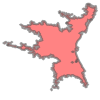

In [35]:
df[df['mode']=='driving'].loc[112,'geom']

In [45]:
from google.cloud import bigquery
from datetime import datetime
client = bigquery.Client()

In [50]:
_ranges = client.query('''
  select 
    mode, 
    _range,
    st_intersection(r.geom, st_boundary(i.geom)) as geom
  from `cartodb-gcp-solutions-eng-team.accesibility.valencia_roads` r
  join`cartodb-gcp-solutions-eng-team.accesibility.isolines` i
  on st_intersects(r.geom, i.geom)
  where not st_isempty(st_intersection(r.geom, st_boundary(i.geom)))
  and (
    (mode='driving' and _range <= 40*60 ) or
    (mode = 'cycling' and _range <=45*60) or
    (mode='public_transport' and _range <= 60*60)
  )
  -- and _range < 10 * 60
  -- group by mode, _range
''').to_geodataframe()

BadRequest: 400 Query exceeded resource limits. This query used 9789 CPU seconds but would charge only 20M Analysis bytes. This exceeds the ratio supported by the on-demand pricing model. Please consider moving this workload to the flat-rate reservation pricing model, which does not have this limit. 9789 CPU seconds were used, and this query must use less than 5100 CPU seconds.

Location: US
Job ID: 1e8d8cc1-01ce-407e-8abb-b44c8f30b5c0


In [48]:
_ranges

,mode,_range,geom
0,cycling,420,POINT (-0.37412 39.45766)
1,cycling,300,POINT (-0.39127 39.46864)
2,driving,540,POINT (-0.39055 39.45908)
3,cycling,360,POINT (-0.37064 39.46530)
4,driving,480,POINT (-0.37056 39.46518)
...,...,...,...
1752,driving,480,POINT (-0.37646 39.46924)
1753,public_transport,360,POINT (-0.37649 39.46924)
1754,driving,420,POINT (-0.37648 39.46924)
1755,driving,540,POINT (-0.38479 39.45970)


In [ ]:
unary_points = []
for mode in _ranges['mode'].unique():
    for _range in sorted(_ranges[_ranges['mode']==mode]._range.unique()):
        unary_points.append({
            'mode': mode,
            '_range': _range,
            'geom': _ranges[(_ranges['mode']==mode ) & _ranges._range <= _range].unary_union
        })

In [ ]:
unary_points_df = pd.DataFrame(unary_points)
unary_points_df_pivot = unary_points_df.pivot(columns='mode', values='geom', index='_range').reset_index()
unary_points_df_pivot['datetime'] = unary_points_df_pivot._range.apply(
    lambda r: pd.to_datetime('2023-06-15T12:00:00Z') + datetime.timedelta(seconds=r)
)
unary_points_df_pivot.rename(columns={'driving': 'geom'}).to_gbq(
    destination_table='accesibility.cycling_with_timestamp',
    project_id='cartodb-gcp-solutions-eng-team',
    if_exists='replace',
    table_schema=[
        {'name': 'geom', 'type': 'GEOGRAPHY'},
        {'name': 'cycling', 'type': 'GEOGRAPHY'},
        {'name': 'public_transport', 'type': 'GEOGRAPHY'}
    ]
)